Help taken from https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277 and https://github.com/bnsreenu/python_for_microscopists/blob/master/097_What%20is%20Median%20denoising.py

In [1]:
import os
import sys
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import color

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from PIL import Image

Using TensorFlow backend.


In [2]:
# Make sure you are using TF verion 1.15.2
tf.__version__

'1.15.2'

In [3]:
# Required image dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


In [ ]:
# 

TRAIN_PATH = '/path_to_train_images'
TEST_PATH = '/path_test_test_images'
MODEL_PATH = '/path_to_model'


seed = 42
random.seed = seed
np.random.seed = seed

In [4]:
# This is for loading a large image, as the default value doesn't allow big images.
Image.MAX_IMAGE_PIXELS = 1000000000  
Image.warnings.simplefilter('error', Image.DecompressionBombWarning)

# Preparing the data

## You dont need to import train data if you are only using it to test your images

In [5]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [7]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + '/'+id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [06:16<00:00,  1.78it/s]


In [8]:
img1 = imread('C:/Users/jashj/Desktop/RA/U Net/Sample_tiles/full/images/full.png')

img=img1[:,:,:3].copy()

resize_height=img.shape[0]//IMG_HEIGHT + 1
resize_height

resize_width=img.shape[0]//IMG_WIDTH + 1
resize_width

X_test = np.zeros((resize_height*resize_width, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

im = resize(img, (resize_height*IMG_HEIGHT, resize_width*IMG_WIDTH,IMG_CHANNELS), mode='constant', preserve_range=True)

n=0
for r in tqdm(range(0,im.shape[0],128)):
    for c in range(0,im.shape[1],128):
#         cv2.imwrite(f"C:/Users/jashj/Desktop/RA/U Net/Sample_tiles/full/img{r}_{c}.png",img[r:r+128, c:c+128,:])
        X_test[n] = im[r:r+128, c:c+128,:]
        n+=1

100%|█████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 167.94it/s]


Let's see if things look all right by drawing some random images and their associated masks.

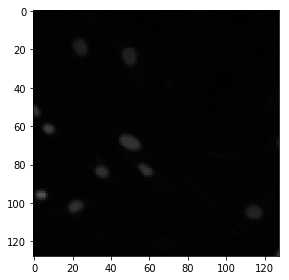

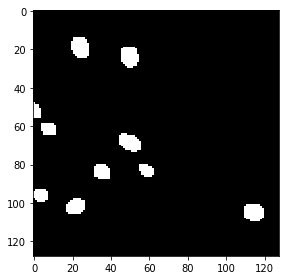

In [9]:

ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

# Create our Keras metric

In [10]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Build and train our neural network
Structure referred from: [Ultrasound Nerve Segmentation](https://github.com/jocicmarko/ultrasound-nerve-segmentation)

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

# Comment the below block if you want to use the pretrained weights and directly predict the output of test images.

In [11]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]      

In [12]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=50, 
                    callbacks=[earlystopper, checkpointer])


Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - ETA: 1:06 - loss: 0.7220 - mean_iou: 0.0000e+ - ETA: 49s - loss: 0.6801 - mean_iou: 0.1965     - ETA: 41s - loss: 0.6575 - mean_iou: 0.261 - ETA: 36s - loss: 0.6286 - mean_iou: 0.294 - ETA: 35s - loss: 0.6165 - mean_iou: 0.315 - ETA: 33s - loss: 0.5972 - mean_iou: 0.328 - ETA: 32s - loss: 0.5902 - mean_iou: 0.338 - ETA: 28s - loss: 0.5674 - mean_iou: 0.346 - ETA: 25s - loss: 0.5575 - mean_iou: 0.353 - ETA: 22s - loss: 0.5495 - mean_iou: 0.359 - ETA: 19s - loss: 0.5426 - mean_iou: 0.363 - ETA: 16s - loss: 0.5363 - mean_iou: 0.367 - ETA: 14s - loss: 0.5304 - mean_iou: 0.370 - ETA: 12s - loss: 0.5213 - mean_iou: 0.373 - ETA: 9s - loss: 0.5123 - mean_iou: 0.376 - ETA: 7s - loss: 0.5009 - mean_iou: 0.37 - ETA: 5s - loss: 0.4914 - mean_iou: 0.38 - ETA: 2s - loss: 0.4812 - mean_iou: 0.38 - 53s 88ms/step - loss: 0.4746 - mean_iou: 0.3857 - val_loss: 0.2702 - val_mean_iou: 0.4430

Epoch 00001: va

603/603 [==============================] - ETA: 35s - loss: 0.0989 - mean_iou: 0.795 - ETA: 33s - loss: 0.0980 - mean_iou: 0.795 - ETA: 31s - loss: 0.0934 - mean_iou: 0.795 - ETA: 30s - loss: 0.0955 - mean_iou: 0.795 - ETA: 28s - loss: 0.0934 - mean_iou: 0.795 - ETA: 26s - loss: 0.0921 - mean_iou: 0.795 - ETA: 25s - loss: 0.0930 - mean_iou: 0.795 - ETA: 22s - loss: 0.0938 - mean_iou: 0.796 - ETA: 20s - loss: 0.0897 - mean_iou: 0.796 - ETA: 18s - loss: 0.0891 - mean_iou: 0.796 - ETA: 16s - loss: 0.0899 - mean_iou: 0.796 - ETA: 14s - loss: 0.0903 - mean_iou: 0.796 - ETA: 12s - loss: 0.0913 - mean_iou: 0.796 - ETA: 10s - loss: 0.0910 - mean_iou: 0.796 - ETA: 8s - loss: 0.0896 - mean_iou: 0.796 - ETA: 5s - loss: 0.0899 - mean_iou: 0.79 - ETA: 3s - loss: 0.0939 - mean_iou: 0.79 - ETA: 1s - loss: 0.0923 - mean_iou: 0.79 - 40s 67ms/step - loss: 0.0916 - mean_iou: 0.7972 - val_loss: 0.0872 - val_mean_iou: 0.7993

Epoch 00016: val_loss did not improve from 0.08362
Epoch 17/50
603/603 [=========

# Make predictions

In [13]:
# Predict on train, val and test
model = load_model(MODEL_PATH, custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (IMG_HEIGHT, IMG_WIDTH), 
                                       mode='constant', preserve_range=True))
    

# Threshold predictions
preds_train_t6 = (preds_train > 0.6).astype(np.uint8)
preds_val_t6 = (preds_val > 0.6).astype(np.uint8)
preds_test_t6 = (preds_test > 0.6).astype(np.uint8)

# Threshold predictions
preds_train_t7 = (preds_train > 0.7).astype(np.uint8)
preds_val_t7 = (preds_val > 0.7).astype(np.uint8)
preds_test_t7 = (preds_test > 0.7).astype(np.uint8)

# Threshold predictions
preds_train_t8 = (preds_train > 0.8).astype(np.uint8)
preds_val_t8 = (preds_val > 0.8).astype(np.uint8)
preds_test_t8 = (preds_test > 0.8).astype(np.uint8)

# Threshold predictions
preds_train_t9 = (preds_train > 0.9).astype(np.uint8)
preds_val_t9 = (preds_val > 0.9).astype(np.uint8)
preds_test_t9 = (preds_test > 0.9).astype(np.uint8)

4761/4761 [==============================] - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 

## Test images print

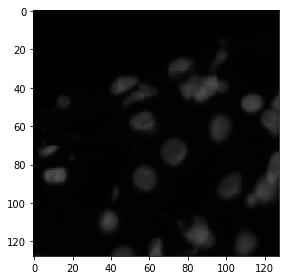

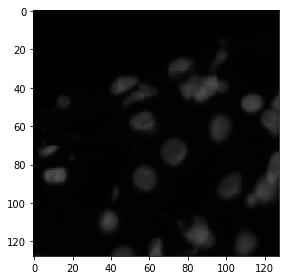

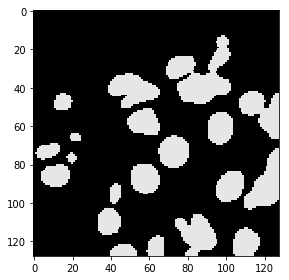

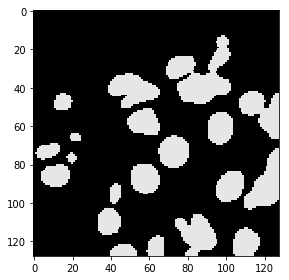

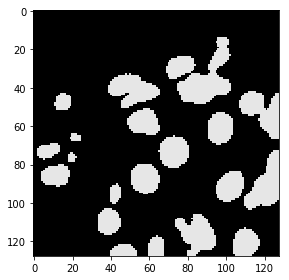

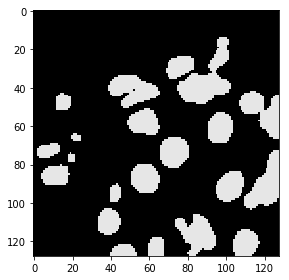

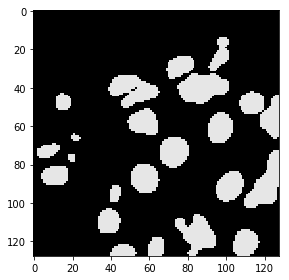

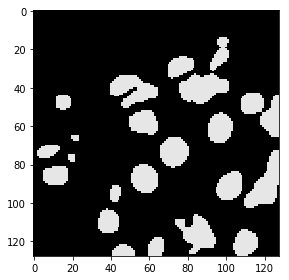

In [17]:
imshow(X_test[ix])
plt.show()
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_t[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_t6[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_t7[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_t8[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_t9[ix]*0.9))
plt.show()

# Storing gray and heatmap images

## Applying blurs

### Median filtering

In [18]:
# for storing output of median blur
X_test_median_cv2 = np.zeros((resize_height*resize_width, IMG_HEIGHT, IMG_WIDTH),dtype=np.uint8)
X_test_median_skimage = np.zeros((resize_height*resize_width, IMG_HEIGHT, IMG_WIDTH),dtype=np.uint8)

X_test_median_cv2_3 = np.zeros((resize_height*resize_width, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),dtype=np.uint8)
X_test_median_skimage_3 = np.zeros((resize_height*resize_width, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),dtype=np.uint8)

In [19]:
import cv2
import numpy as np
from scipy.ndimage.filters import convolve
from skimage import io
from skimage.filters import median
from skimage.morphology import disk
#img = io.imread('images/einstein.jpg', as_gray=True)

#Needs 8 bit, not float.
# img_gaussian_noise = cv2.imread('images/BSE_25sigma_noisy.jpg', 0)
# img_salt_pepper_noise = cv2.imread('images/BSE_salt_pepper.jpg', 0)

# img = img_salt_pepper_noise

n=0
for i in  X_test:
    
    tempo=np.dot(i[...,:3], [0.299, 0.587, 0.114]).astype(np.uint8)

    median_using_cv2 = cv2.medianBlur(tempo, 3)
    X_test_median_cv2[n]=median_using_cv2
    X_test_median_cv2_3[n]=color.gray2rgb(median_using_cv2)

    median_using_skimage = median(tempo, disk(3), mode='constant', cval=0.0)
    
    X_test_median_skimage[n]=median_using_skimage
    X_test_median_skimage_3[n]=color.gray2rgb(median_using_skimage)

    
    n=n+1


# cv2.imshow("Original", img)
# cv2.imshow("cv2 median", median_using_cv2)
# cv2.imshow("Using skimage median", median_using_skimage)

# cv2.waitKey(0)          
# cv2.destroyAllWindows() 

In [20]:
# ix = random.randint(0, len(X_test))

In [21]:
# ix=1581

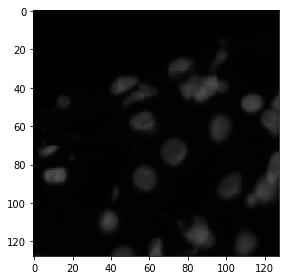

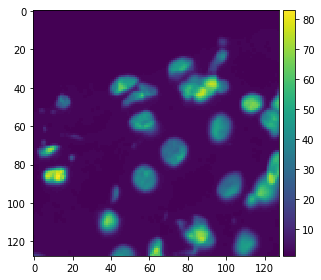

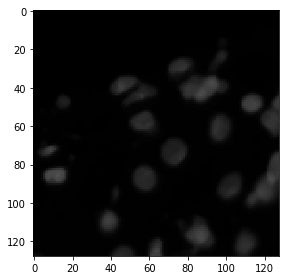

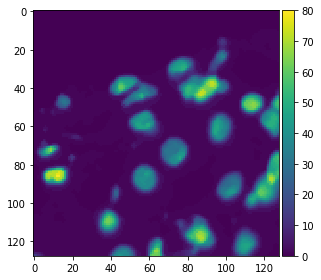

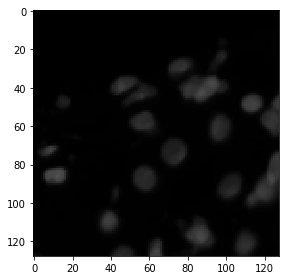

In [22]:
imshow(X_test[ix])
plt.show()
imshow(np.dot(X_test[ix][...,:3], [0.299, 0.587, 0.114]))
plt.show()
imshow(X_test_median_cv2[ix])
plt.show()
imshow(X_test_median_cv2[ix].astype(np.float64))
plt.show()
imshow(X_test_median_cv2_3[ix])
plt.show()

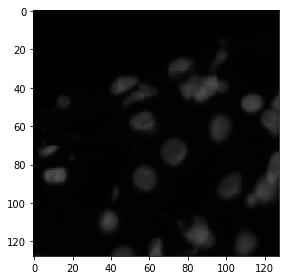

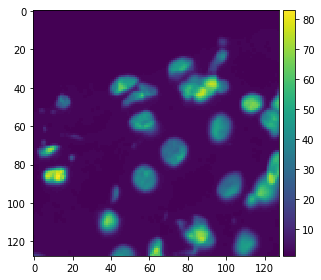

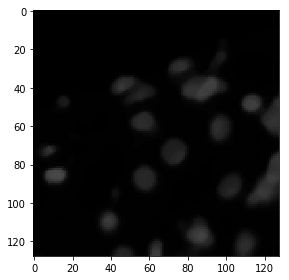

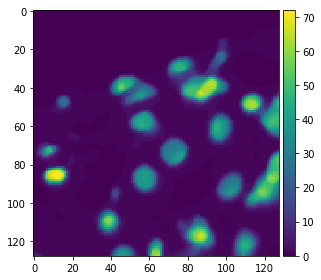

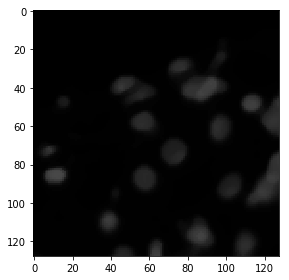

In [23]:
imshow(X_test[ix])
plt.show()
imshow(np.dot(X_test[ix][...,:3], [0.299, 0.587, 0.114]))
plt.show()
imshow(X_test_median_skimage[ix])
plt.show()
imshow(X_test_median_skimage[ix].astype(np.float64))
plt.show()
imshow(X_test_median_skimage_3[ix])
plt.show()

# Testing filtered images

In [24]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)
preds_test_cv2 = model.predict(X_test_median_cv2_3, verbose=1)
preds_test_skimage = model.predict(X_test_median_skimage_3, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
preds_test_cv2_t = (preds_test_cv2 > 0.5).astype(np.uint8)
preds_test_skimage_t = (preds_test_skimage > 0.5).astype(np.uint8)


# Threshold predictions
preds_train_t6 = (preds_train > 0.6).astype(np.uint8)
preds_val_t6 = (preds_val > 0.6).astype(np.uint8)
preds_test_t6 = (preds_test > 0.6).astype(np.uint8)
preds_test_cv2_t6 = (preds_test_cv2 > 0.6).astype(np.uint8)
preds_test_skimage_t6 = (preds_test_skimage > 0.6).astype(np.uint8)


# Threshold predictions
preds_train_t7 = (preds_train > 0.7).astype(np.uint8)
preds_val_t7 = (preds_val > 0.7).astype(np.uint8)
preds_test_t7 = (preds_test > 0.7).astype(np.uint8)
preds_test_cv2_t7 = (preds_test_cv2 > 0.7).astype(np.uint8)
preds_test_skimage_t7 = (preds_test_skimage > 0.7).astype(np.uint8)


# Threshold predictions
preds_train_t8 = (preds_train > 0.8).astype(np.uint8)
preds_val_t8 = (preds_val > 0.8).astype(np.uint8)
preds_test_t8 = (preds_test > 0.8).astype(np.uint8)
preds_test_cv2_t8 = (preds_test_cv2 > 0.8).astype(np.uint8)
preds_test_skimage_t8 = (preds_test_skimage > 0.8).astype(np.uint8)


# Threshold predictions
preds_train_t9 = (preds_train > 0.9).astype(np.uint8)
preds_val_t9 = (preds_val > 0.9).astype(np.uint8)
preds_test_t9 = (preds_test > 0.9).astype(np.uint8)
preds_test_cv2_t9 = (preds_test_cv2 > 0.9).astype(np.uint8)
preds_test_skimage_t9 = (preds_test_skimage > 0.9).astype(np.uint8)


preds_train_t95 = (preds_train > 0.95).astype(np.uint8)
preds_val_t95 = (preds_val > 0.95).astype(np.uint8)
preds_test_t95 = (preds_test > 0.95).astype(np.uint8)
preds_test_cv2_t95 = (preds_test_cv2 > 0.95).astype(np.uint8)
preds_test_skimage_t95 = (preds_test_skimage > 0.95).astype(np.uint8)

4761/4761 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA:

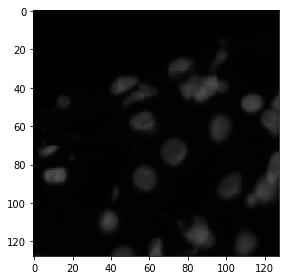

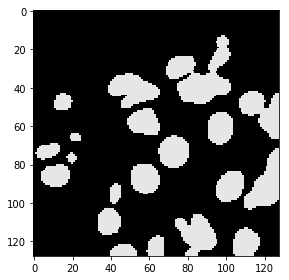

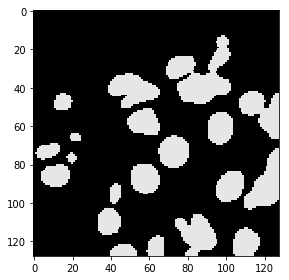

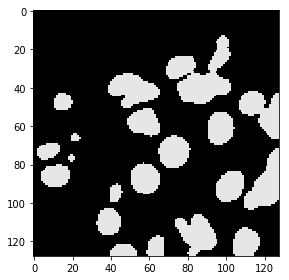

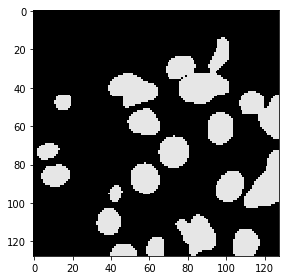

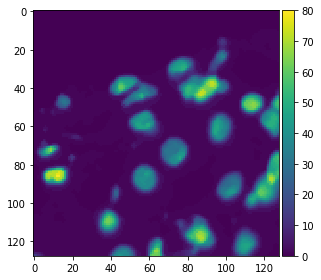

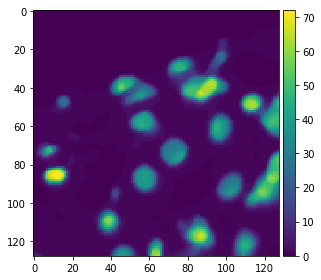

In [25]:

imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_t[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_cv2_t[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_skimage_t[ix]*0.9))
plt.show()
imshow(X_test_median_cv2[ix].astype(np.float64))
plt.show()
imshow(X_test_median_skimage[ix].astype(np.float64))
plt.show()

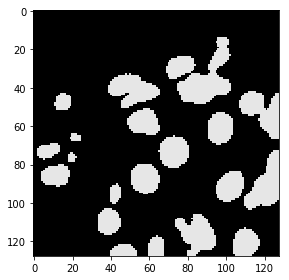

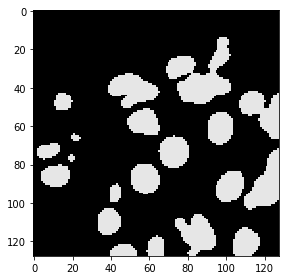

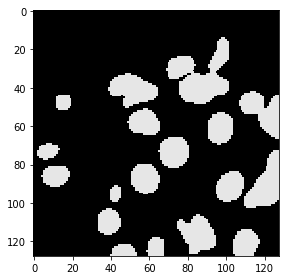

In [26]:
imshow(np.squeeze(preds_test_t6[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_cv2_t6[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_skimage_t6[ix]*0.9))
plt.show()

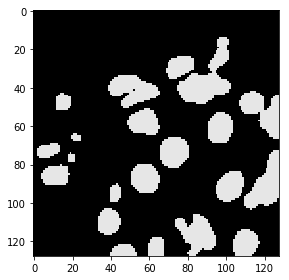

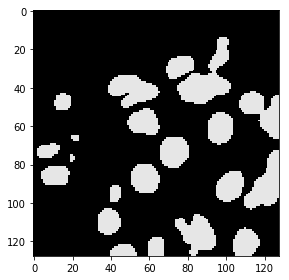

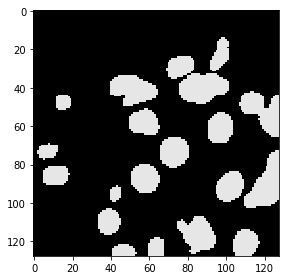

In [27]:
imshow(np.squeeze(preds_test_t7[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_cv2_t7[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_skimage_t7[ix]*0.9))
plt.show()

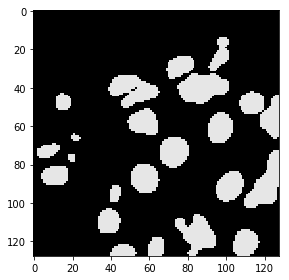

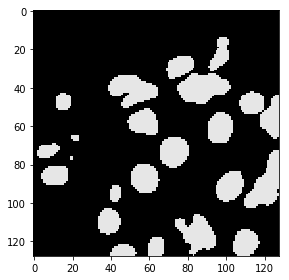

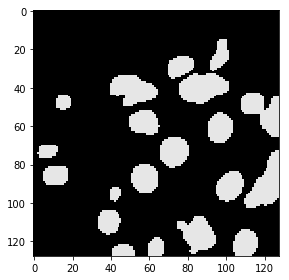

In [28]:
imshow(np.squeeze(preds_test_t8[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_cv2_t8[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_skimage_t8[ix]*0.9))
plt.show()

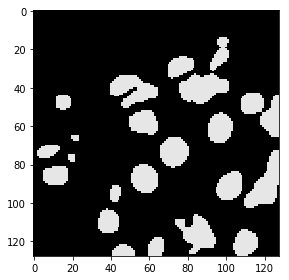

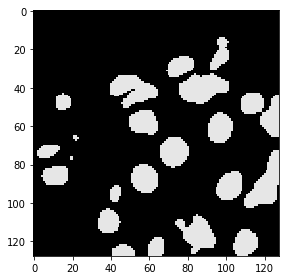

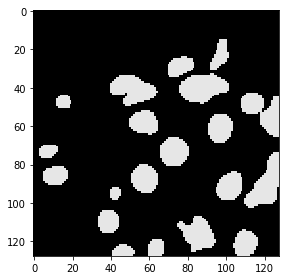

In [29]:
imshow(np.squeeze(preds_test_t9[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_cv2_t9[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_skimage_t9[ix]*0.9))
plt.show()

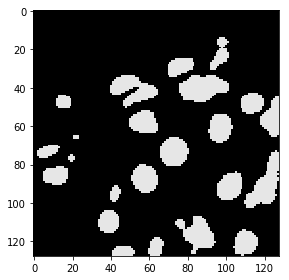

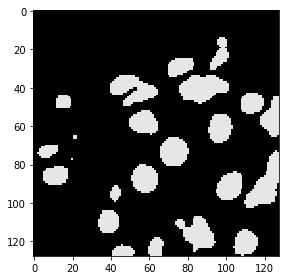

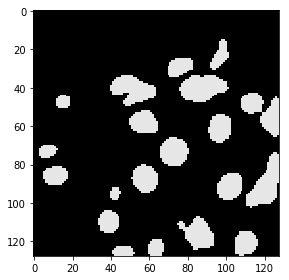

In [30]:
imshow(np.squeeze(preds_test_t95[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_cv2_t95[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_skimage_t95[ix]*0.9))
plt.show()

In [31]:
# preds_train_t95 = (preds_train > 0.95).astype(np.uint8)
# preds_val_t95 = (preds_val > 0.95).astype(np.uint8)
# preds_test_t95 = (preds_test > 0.95).astype(np.uint8)
# preds_test_cv2_t95 = (preds_test_cv2 > 0.95).astype(np.uint8)
# preds_test_skimage_t95 = (preds_test_skimage > 0.95).astype(np.uint8)

In [32]:
preds_train_t98 = (preds_train > 0.98).astype(np.uint8)
preds_val_t98 = (preds_val > 0.98).astype(np.uint8)
preds_test_t98 = (preds_test > 0.98).astype(np.uint8)
preds_test_cv2_t98 = (preds_test_cv2 > 0.98).astype(np.uint8)
preds_test_skimage_t98 = (preds_test_skimage > 0.98).astype(np.uint8)

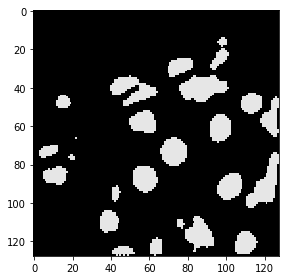

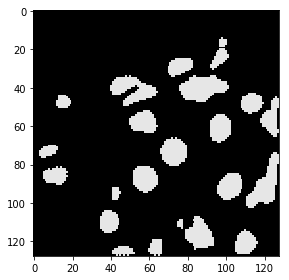

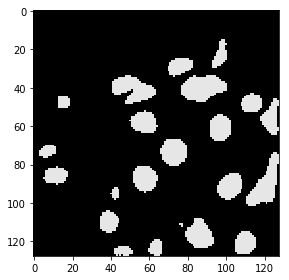

In [33]:
imshow(np.squeeze(preds_test_t98[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_cv2_t98[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_skimage_t98[ix]*0.9))
plt.show()

In [34]:
preds_train_t99 = (preds_train > 0.99).astype(np.uint8)
preds_val_t99 = (preds_val > 0.99).astype(np.uint8)
preds_test_t99 = (preds_test > 0.99).astype(np.uint8)
preds_test_cv2_t99 = (preds_test_cv2 > 0.99).astype(np.uint8)
preds_test_skimage_t99 = (preds_test_skimage > 0.99).astype(np.uint8)

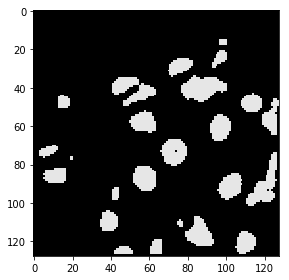

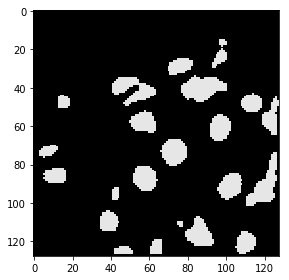

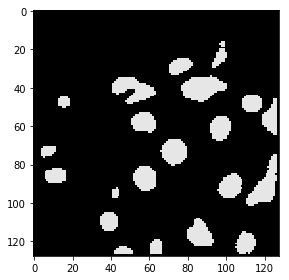

In [35]:
imshow(np.squeeze(preds_test_t99[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_cv2_t99[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_skimage_t99[ix]*0.9))
plt.show()

In [36]:
preds_train_t995 = (preds_train > 0.995).astype(np.uint8)
preds_val_t995 = (preds_val > 0.995).astype(np.uint8)
preds_test_t995 = (preds_test > 0.995).astype(np.uint8)
preds_test_cv2_t995 = (preds_test_cv2 > 0.995).astype(np.uint8)
preds_test_skimage_t995 = (preds_test_skimage > 0.995).astype(np.uint8)

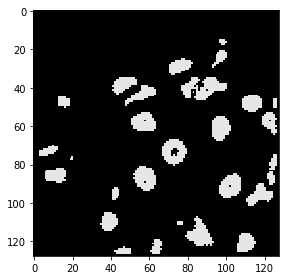

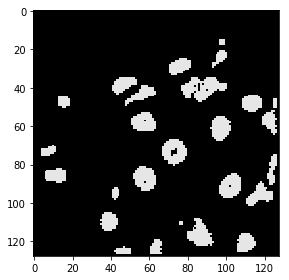

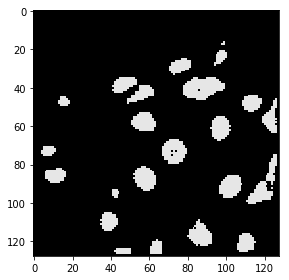

In [37]:
imshow(np.squeeze(preds_test_t995[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_cv2_t995[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_skimage_t995[ix]*0.9))
plt.show()

In [38]:
preds_train_t996 = (preds_train > 0.996).astype(np.uint8)
preds_val_t996 = (preds_val > 0.996).astype(np.uint8)
preds_test_t996 = (preds_test > 0.996).astype(np.uint8)
preds_test_cv2_t996 = (preds_test_cv2 > 0.996).astype(np.uint8)
preds_test_skimage_t996 = (preds_test_skimage > 0.996).astype(np.uint8)

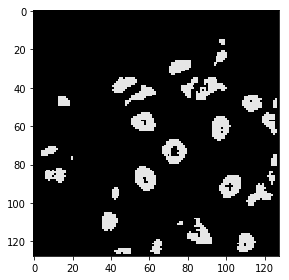

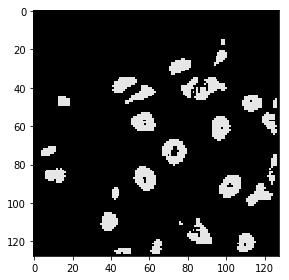

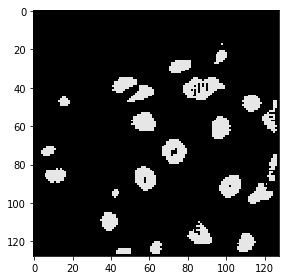

In [39]:
imshow(np.squeeze(preds_test_t996[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_cv2_t996[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_skimage_t996[ix]*0.9))
plt.show()

In [40]:
preds_train_t997 = (preds_train > 0.997).astype(np.uint8)
preds_val_t997 = (preds_val > 0.997).astype(np.uint8)
preds_test_t997 = (preds_test > 0.997).astype(np.uint8)
preds_test_cv2_t997 = (preds_test_cv2 > 0.997).astype(np.uint8)
preds_test_skimage_t997 = (preds_test_skimage > 0.997).astype(np.uint8)

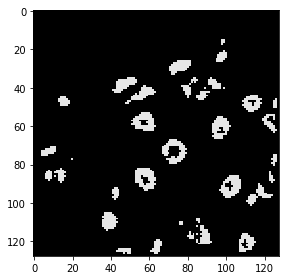

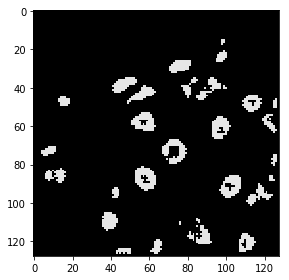

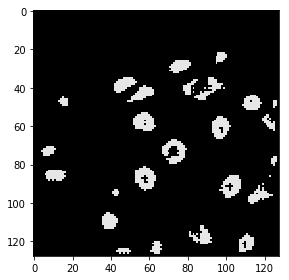

In [41]:
imshow(np.squeeze(preds_test_t997[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_cv2_t997[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_skimage_t997[ix]*0.9))
plt.show()

In [42]:
preds_train_t999 = (preds_train > 0.999).astype(np.uint8)
preds_val_t999 = (preds_val > 0.999).astype(np.uint8)
preds_test_t999 = (preds_test > 0.999).astype(np.uint8)
preds_test_cv2_t999 = (preds_test_cv2 > 0.999).astype(np.uint8)
preds_test_skimage_t999 = (preds_test_skimage > 0.999).astype(np.uint8)

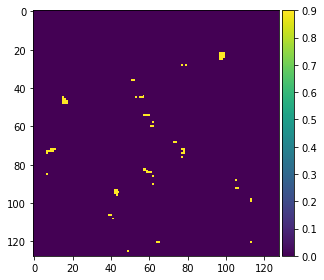

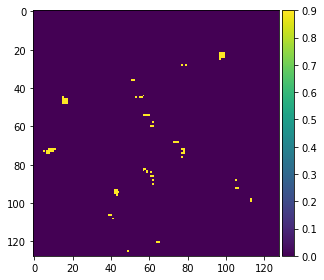

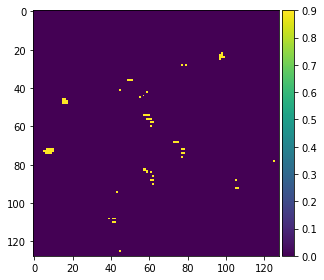

In [43]:
imshow(np.squeeze(preds_test_t999[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_cv2_t999[ix]*0.9))
plt.show()
imshow(np.squeeze(preds_test_skimage_t999[ix]*0.9))
plt.show()

# Smoothning the result from U Net

In [3]:
# ix

In [45]:
kernel = np.ones((2,2),np.uint8)
    
opening = cv2.morphologyEx(preds_test_cv2_t996[ix], cv2.MORPH_OPEN, kernel, iterations=1)

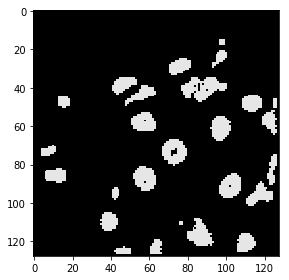

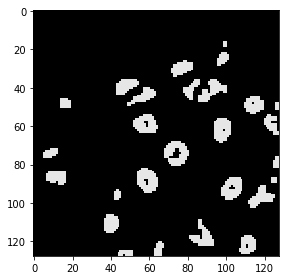

In [46]:
imshow(np.squeeze(preds_test_cv2_t995[ix])*0.9)
plt.show()

imshow(opening*0.9)
plt.show()

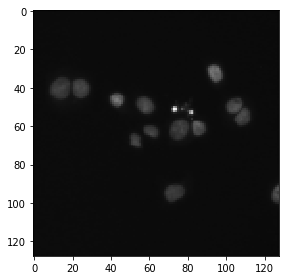

In [47]:
imshow(X_train[5])
plt.show()

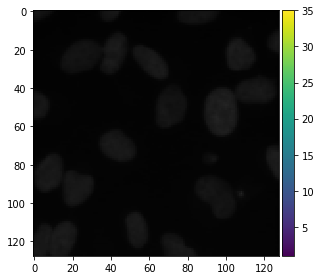

In [48]:
imshow(X_train[14])
plt.show()

# Importing latest Test Data

In [53]:
# Get and resize test images

img1 = imread('C:/Users/jashj/Desktop/RA/U Net/test2/image001.png')

# img1 = imread('C:/Users/jashj/Desktop/RA/U Net/Sample_tiles/full/images/full.png')

img=img1[:,:,:3].copy()

# resize_height=img.shape[0]//IMG_HEIGHT + 1
resize_height=img.shape[0]//IMG_HEIGHT
resize_height

# resize_width=img.shape[0]//IMG_WIDTH + 1
resize_width=img.shape[0]//IMG_WIDTH
resize_width

X_test = np.zeros((resize_height*resize_width, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

im = resize(img, (resize_height*IMG_HEIGHT, resize_width*IMG_WIDTH,IMG_CHANNELS), mode='constant', preserve_range=True)

n=0
for r in tqdm(range(0,im.shape[0],128)):
    for c in range(0,im.shape[1],128):
#         cv2.imwrite(f"C:/Users/jashj/Desktop/RA/U Net/Sample_tiles/full/img{r}_{c}.png",img[r:r+128, c:c+128,:])
        X_test[n] = im[r:r+128, c:c+128,:]
        n+=1

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2004.45it/s]


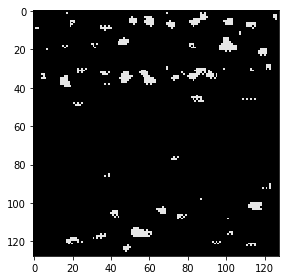

In [54]:
imshow(np.squeeze(preds_test__kaggle_t9[ix])*0.9)
plt.show()

In [55]:
X_test.shape

(4, 128, 128, 3)

In [56]:
# Predict on kaggle test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_latest_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_latest_test_t = (preds_latest_test > 0.5).astype(np.uint8)
preds_latest_test_t6 = (preds_latest_test > 0.6).astype(np.uint8)
preds_latest_test_t7 = (preds_latest_test > 0.7).astype(np.uint8)
preds_latest_test_t8 = (preds_latest_test > 0.8).astype(np.uint8)
preds_latest_test_t9 = (preds_latest_test > 0.9).astype(np.uint8)
preds_latest_test_t95 = (preds_latest_test > 0.95).astype(np.uint8)
preds_latest_test_t98 = (preds_latest_test > 0.98).astype(np.uint8)
preds_latest_test_t99 = (preds_latest_test > 0.99).astype(np.uint8)
preds_latest_test_t995 = (preds_latest_test > 0.995).astype(np.uint8)
preds_latest_test_t996 = (preds_latest_test > 0.996).astype(np.uint8)
preds_latest_test_t997 = (preds_latest_test > 0.997).astype(np.uint8)

4/4 [==============================] - 1s 219ms/step


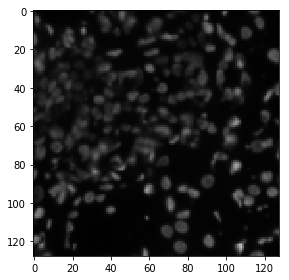

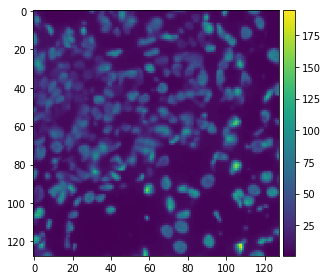

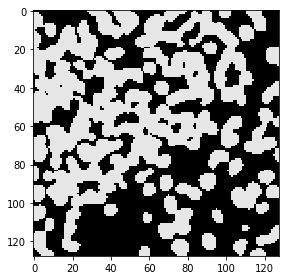

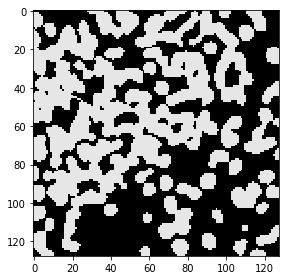

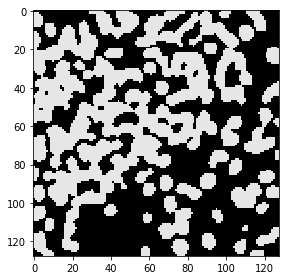

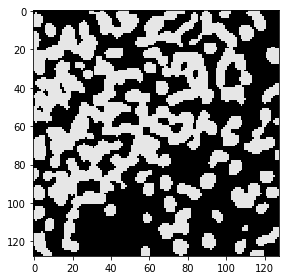

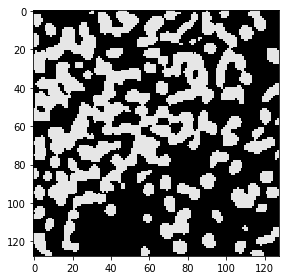

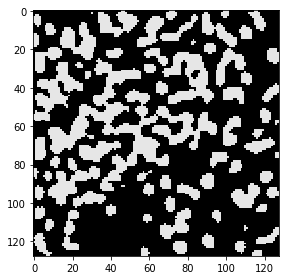

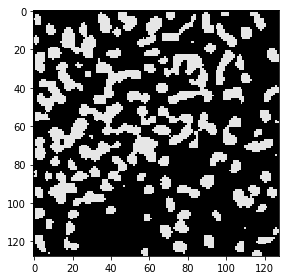

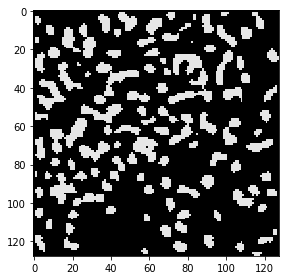

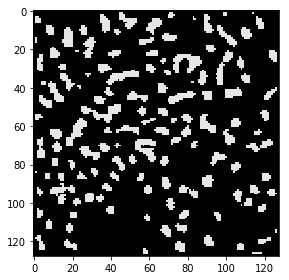

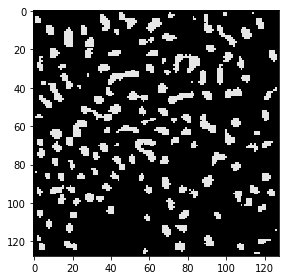

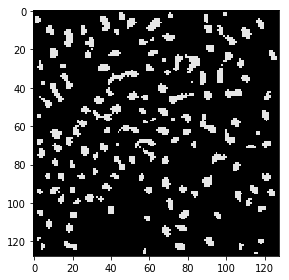

In [57]:
imshow(np.squeeze(X_test[0]))
plt.show()
imshow(np.squeeze(np.dot(X_test[0][...,:3], [0.299, 0.587, 0.114])))
plt.show()
imshow(np.squeeze(preds_latest_test_t[0])*0.9)
plt.show()
imshow(np.squeeze(preds_latest_test_t6[0])*0.9)
plt.show()
imshow(np.squeeze(preds_latest_test_t7[0])*0.9)
plt.show()
imshow(np.squeeze(preds_latest_test_t8[0])*0.9)
plt.show()
imshow(np.squeeze(preds_latest_test_t9[0])*0.9)
plt.show()
imshow(np.squeeze(preds_latest_test_t95[0])*0.9)
plt.show()
imshow(np.squeeze(preds_latest_test_t98[0])*0.9)
plt.show()
imshow(np.squeeze(preds_latest_test_t99[0])*0.9)
plt.show()
imshow(np.squeeze(preds_latest_test_t995[0])*0.9)
plt.show()
imshow(np.squeeze(preds_latest_test_t996[0])*0.9)
plt.show()
imshow(np.squeeze(preds_latest_test_t997[0])*0.9)
plt.show()


# Combining images

In [ ]:
ix

In [ ]:
X_test.shape

In [ ]:
X_test = np.zeros((resize_height*resize_width, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

im = resize(img, (resize_height*IMG_HEIGHT, resize_width*IMG_WIDTH,IMG_CHANNELS), mode='constant', preserve_range=True)


In [ ]:
resize_height*resize_width, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS

In [ ]:
img.shape

In [ ]:
X_test_combined=np.zeros((resize_height*IMG_HEIGHT,resize_width*IMG_WIDTH,1), dtype=np.uint8)
X_test_combined_gray=np.zeros((resize_height*IMG_HEIGHT,resize_width*IMG_WIDTH,1), dtype=np.uint8)
X_test_combined_pred_cv2 = np.zeros((resize_height*IMG_HEIGHT,resize_width*IMG_WIDTH,1), dtype=np.uint8)
X_test_combined_pred_skimage = np.zeros((resize_height*IMG_HEIGHT,resize_width*IMG_WIDTH,1), dtype=np.uint8)



X_test_combined_median_cv2 = np.zeros((resize_height*IMG_HEIGHT,resize_width*IMG_WIDTH,1), dtype=np.uint8)
X_test_combined_median_skimage = np.zeros((resize_height*IMG_HEIGHT,resize_width*IMG_WIDTH,1), dtype=np.uint8)



In [ ]:
temp1=np.zeros((IMG_HEIGHT,IMG_WIDTH,1), dtype=np.uint8)
temp2=np.zeros((IMG_HEIGHT,IMG_WIDTH,1), dtype=np.uint8)

for i in range(resize_height):
#     temp1=X_test[0]
    for j in range(resize_width):
        print(j*IMG_HEIGHT,(j+1)*IMG_HEIGHT,(i)*IMG_HEIGHT,(i+1)*IMG_HEIGHT ,i*resize_width+j    )
#         print(j*IMG_WIDTH,(j+1)*IMG_WIDTH,j*IMG_HEIGHT,(j+1)*IMG_HEIGHT,1)
#         print(i*resize_width+j)
        X_test_combined[(i)*IMG_HEIGHT:(i+1)*IMG_HEIGHT,j*IMG_HEIGHT:(j+1)*IMG_HEIGHT,:]=preds_test_t[i*resize_width+j]
        
        

In [77]:
temp1.shape

(128, 128, 1)

In [78]:
X_test_combined.shape

(384, 384, 1)

In [79]:
IMG_HEIGHT

128

In [88]:
X_test_combined.shape

(384, 384, 1)

In [89]:
preds_test_t[i*resize_width+j].shape

(128, 128, 1)

In [93]:
X_test_combined[j*IMG_WIDTH:(j+1)*IMG_WIDTH,j*IMG_HEIGHT:(j+1)*IMG_HEIGHT,:].shape

(128, 128, 1)

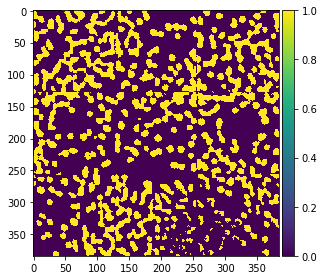

In [145]:
imshow(np.squeeze(X_test_combined))
plt.show()

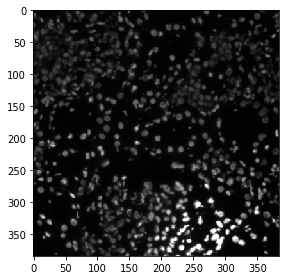

In [138]:
imshow(im/255)
plt.show()

In [135]:
im

array([[[16.57592773, 16.57592773, 16.57592773],
        [14.64953613, 14.64953613, 14.64953613],
        [10.42839898, 10.42839898, 10.42839898],
        ...,
        [ 3.04140896,  3.04140896,  3.04140896],
        [ 3.92744954,  3.92744954,  3.92744954],
        [ 4.60442437,  4.60442437,  4.60442437]],

       [[24.02832031, 24.02832031, 24.02832031],
        [24.5826416 , 24.5826416 , 24.5826416 ],
        [16.90498861, 16.90498861, 16.90498861],
        ...,
        [ 4.36564128,  4.36564128,  4.36564128],
        [ 6.90063477,  6.90063477,  6.90063477],
        [ 8.99556478,  8.99556478,  8.99556478]],

       [[24.30182563, 24.30182563, 24.30182563],
        [27.99527995, 27.99527995, 27.99527995],
        [23.3423801 , 23.3423801 , 23.3423801 ],
        ...,
        [ 7.30863444,  7.30863444,  7.30863444],
        [12.42582194, 12.42582194, 12.42582194],
        [17.88825141, 17.88825141, 17.88825141]],

       ...,

       [[ 1.71379937,  1.71379937,  1.71379937],
        [ 1